# Graphlet Correlation Analysis

Remember, in notebook *Thresholding*, I thresholded contact maps and saved so that
orca can read them.

In this notebook, I perform two actions:
1. I apply `count5` procedure in orca to extract 73 orbits for each loci in each
chromosome. After this stage, graphlets will be save with `.graphlets` extension 
in the `./data` folder.

2. I then read the graphlets and find both loci-wise distance
and graphlet-wise correlations
between the four cell lines.

By repeating steps 1 and 2 for all 23 chromosomes, I will have pairwise MIC values for all
orbits of all cell lines. I would eventually be able to have a data array of shape
``` A(23 * 73) ```, for each pair of cell lines where `A[i, j]` denotes the correlation
between the jth orbit in the ith chromosome. 


In [158]:
import numpy as np
import cv2
from utility import *
import matplotlib.pyplot as plt
from iced import normalization
from iced import filter
import os
from scipy.interpolate import spline
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/git/watson/virt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'indices', 'axis', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [159]:
data_names = ["MIT", "ALL", "RL", "CALL4"]
root = "/home/bzr0014/watson/data/"
file_dir_template = "%s/extracted_all_contact_%s"%(root,"%s")
file_name_template = "%s/all_in_one_500kb.npy"%(file_dir_template)
print("File Directory: \"%s\""%file_dir_template)
print("File Name Template: \"%s\""%file_name_template)

mit_colors = ['#0d75f8', '#42b395', '#99cc04']
cancer_colors = ['#ab1239', '#c83cb9', '#cf524e']

File Directory: "/home/bzr0014/watson/data//extracted_all_contact_%s"
File Name Template: "/home/bzr0014/watson/data//extracted_all_contact_%s/all_in_one_500kb.npy"


## Extracting orbits from thresholded files

## Reading Already saved orbits

In [160]:
graphlets = {}
for cell in data_names:
    graphlets[cell] = {}
    count = 0
    for chr1 in range(1, 24):
        graphlets[cell][chr1] = {}
        for chr2 in range(chr1, 24):
            graphlets[cell][chr1][chr2] = readMat\
            ("%s/data/chr%02d_chr%02d_%s.graphlets"%(root, chr1, chr2, cell.lower()), delimiter=" ").astype('uint32') 
            count += 1

## Putting extracted graphlets in order
The following code block assembles all 23 orbit signature vectors of a loci into a $23 \times 73$ matrix.

In [161]:
lengths = {}
for key in data_names:
    print(key)
    lengths[key] = np.load("%s/lengths_500kb.npy"%(file_dir_template%key))            

num_loci = 100000
loci_data = {}
for cell1 in data_names:
    loci_data[cell1] = {}
    num_loci = int(np.min([np.sum(lengths[cell1][-1]), num_loci]))
    print num_loci
    for l in range(num_loci+1):
        loci_data[cell1][l] = np.zeros((24, 73), dtype='uint32')

for cell1 in data_names:
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            l1 = lengths[cell1][chr1, :]
            l2 = lengths[cell1][chr2, :]
            temp = graphlets[cell1][chr1][chr2]
            if chr1 == chr2:
                for l in range(len(temp)):
                    loci_abs_num = l1[0] + l
                    loci_data[cell1][loci_abs_num][chr1] = temp[l]                
            else:
                for l in range(l1[1]):
                    loci_abs_num = l1[0] + l
                    loci_data[cell1][loci_abs_num][chr2] = temp[l]                
                for l in range(l1[1], len(temp)):
                    loci_abs_num = l2[0] + l - l1[1]
                    loci_data[cell1][loci_abs_num][chr1] = temp[l]                
                

MIT
ALL
RL
CALL4
6053
6053
6053
6053


In [162]:
# Test of the above procedure, the absolute difference should be 0
sum_diffs = 0
for cell_index in np.random.randint(0, len(data_names), size=3):
    cell = data_names[cell_index]
    for chr1 in np.random.choice(range(1, 24), size=3):
        for chr2 in np.random.choice(range(1, 24), size=3):
            i = np.argmin([chr1, chr2])
            if i == 1:
                c1 = chr2
                c2 = chr1
            else:
                c1 = chr1
                c2 = chr2
            for loci in np.random.choice(range(lengths[cell][c1, 1]), size=3):
                sum_diffs += int(np.sum(np.abs(loci_data[cell][loci + lengths[cell][c1, 0]][c2] - graphlets[cell][c1][c2][loci])))
print("Absolute Diference: %d"%(sum_diffs))
print len(loci_data['MIT'])

Absolute Diference: 0
6054


In [163]:
## Saving files
#for cell in data_names:
#    for loci in range(num_loci):
#            file_name = "data/%s_loci%d"%(cell, loci)
#            print(file_name)
#            np.save(file_name, loci_data[cell][loci])

## Calculating Loci-wise distances:
Now we can compare contact maps with each other based on
the *signature distance* measure. For each contact map
and each pair of cells, we can perform a t-test on
the signature distances in order to see whether the
differences are 0 or not. In the following code
blocks, first we calculate the signature distances
between each pair of cells and then some visualizaitons
demonstrate how cells are different.

In [164]:
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
        
cells = ['mit', 'all', 'rl', 'call4']
graphlets = {}
for cell in cells:
    graphlets[cell] = {}
    for chr1 in range(1, 24):
        graphlets[cell][chr1] = {}
        for chr2 in range(chr1, 24):
            graphlets[cell][chr1][chr2] = readMat\
            ("%s/data/chr%02d_chr%02d_%s.graphlets"%\
             (root, chr1, chr2, cell), delimiter=" ").astype('uint32') 
        
distances = {}
actual_distances = {}
for cell in cells:
    distances[cell] = {}
    actual_distances[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        distances[cell1][cell2] = np.zeros((count, 4))
        distances[cell2][cell1] = distances[cell1][cell2]
        actual_distances[cell1][cell2] = [None] * (count)
        actual_distances[cell2][cell1] = actual_distances[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        print(cell1, cell2)
        for chr1 in range(1, 24):
            for chr2 in range(chr1, 24):
                count = chr2count[(chr1, chr2)]
                temp =  row_wise_graphlet_distance(graphlets[cell1][chr1][chr2]\
                                , graphlets[cell2][chr1][chr2])
                actual_distances[cell1][cell2][count] = temp
                distances[cell1][cell2][count, 0] = np.nanmean(temp)
                distances[cell1][cell2][count, 1] = np.nanstd(temp, ddof=1)
                t0, pvalue = t_test(temp, one_sided=True)
                distances[cell1][cell2][count, 2] = t0
                distances[cell1][cell2][count, 3] = pvalue

('mit', 'rl')
('all', 'mit')
('all', 'rl')
('all', 'call4')
('call4', 'mit')
('call4', 'rl')


In [165]:
sameIndices = []
for chr1 in range(1, 24):
    sameIndices.append(chr2count[(chr1, chr1)])
print("Same indices: %s\n"%sameIndices)
differentIndices = []
for chr1 in range(1, 24):
    for chr2 in range(chr1+1, 24):
        differentIndices.append(chr2count[(chr1, chr2)])
print("Different indices: %s"%differentIndices)

Same indices: [0, 23, 45, 66, 86, 105, 123, 140, 156, 171, 185, 198, 210, 221, 231, 240, 248, 255, 261, 266, 270, 273, 275]

Different indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203,

### All pair-wise signature distances
The following is a graph comparing contact maps in terms of average loci-loci distances. For each pair of cells
$A$ and $B$, $\bar{d}^{\hspace{.2cm}A,B}_{ij}$ is calculated. As can be seen in the third graph, which also shows
errors of half standard deviation, we can see that almost none
of the graphlet distances are not within half a standard
deviation of zero.

/home/bzr0014/git/watson/virt/lib/python2.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


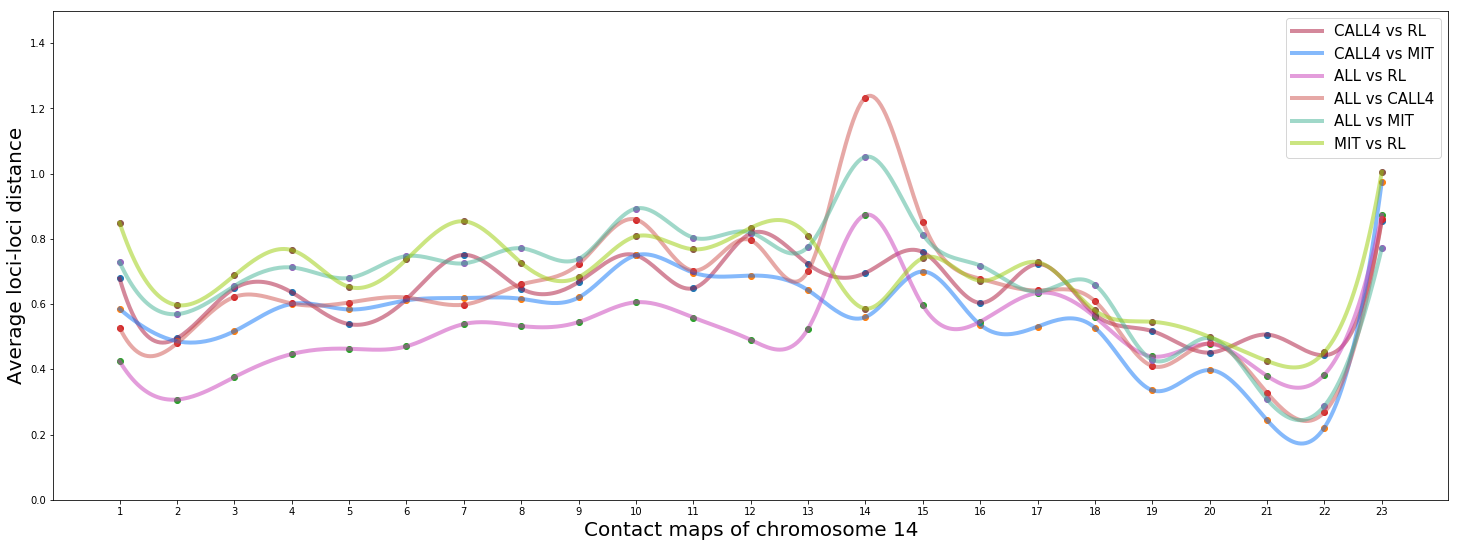

In [285]:
pylab.rcParams['figure.figsize'] = (200, 90)
myIndices = []
chr1 = 14
for chr2 in range(1, 24):
    if chr1 < chr2:
        myIndices.append(chr2count[(chr1, chr2)])
    else:
        myIndices.append(chr2count[(chr2, chr1)])
pylab.rcParams['figure.figsize'] = (25, 9)
mit_count = cancer_count = 0
x = range(len(distances['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    for cell2 in distances[cell1]:
        if cell1 >= cell2:
            continue
        y = distances[cell1][cell2][myIndices, 0]
        x = np.arange(len(y))+1
        xnew = np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
        y_smooth = spline(x, y,xnew)
        ax.scatter(x, y)
        if cell1 == 'mit' or cell2 == 'mit':
            color = mit_colors[mit_count]
            mit_count += 1
        else:
            color = cancer_colors[cancer_count]        
            cancer_count += 1
        ax.plot(xnew, y_smooth, marker=" ", label="%s vs %s"%(cell1.upper(), cell2.upper())\
                , linewidth=4,  alpha=.5, color=color)       
        #ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1.5])
        ax.set_ylabel('Average loci-loci distance', fontsize=20)
        ax.set_xlabel('Contact maps of chromosome %d'%(chr1), fontsize=20)
        ax.set_xticks(x)

plt.legend(prop={'size':15})
plt.show()

# MIC Analysis

In [45]:
header = "MIT,ALL,RL,CALL4"
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        for orbit in range(72, 73):
            filename = "%s/data/chr%02d_chr%02d_orbit%02d.csv"%(root, chr1, chr2, orbit)
            n = 100000000
            for cell in data_names:
                cell = cell.upper()
                n = np.min([graphlets[cell][chr1][chr2][:, orbit].shape[0], n])
            temp = np.zeros((n, len(data_names)))
            count = 0
            for cell in data_names:
                cell = cell.upper()
                temp[:, count] = graphlets[cell][chr1][chr2][:n, orbit]
                count += 1
            np.savetxt(filename, temp, delimiter=',', header=header)

In [46]:
#for chr1 in range(1, 24):
#    for chr2 in range(chr1, 24):
#        for orbit in range(73):
#            file_name = "data/chr%02d_chr%02d_orbit%02d.csv"%(chr1, chr2, orbit)
#            command = "java -jar mine.jar %s -allPairs"%file_name
#            print(command)
#            os.system(command)

In [47]:
cells = ['mit', 'all', 'rl', 'call4']
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
        
mics = {}
for cell in cells:
    mics[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        mics[cell1][cell2] = np.zeros((count, 73))
        mics[cell2][cell1] = mics[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
#for cell1 in cells:
#    for cell2 in cells:
#        if cell2 <= cell1:
#            continue
#        print(cell1, cell2)
#        count = 0 
#        for chr1 in range(1, 24):
#            for chr2 in range(chr1, 24):
#                mics[cell1][cell2][count, :] =  row_wise_pearson(graphlets[cell1][chr1][chr2].T\
#                                , graphlets[cell2][chr1][chr2].T)
#                count+=1
import string
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        for orbit in range(73):
            filename = "%s/data/chr%02d_chr%02d_orbit%02d.csv,allpairs,cv=0.0,B=n^0.6,Results.csv"\
            %(root, chr1, chr2, orbit)
            print(filename)
            csvfile = open(filename, 'r')
            csvfile.readline()
            for line in csvfile:
                splitted = line.split(',')
                a = string.replace(splitted[0], "# ", "").lower()
                b = string.replace(splitted[1], "# ", "").lower()
                c = float(splitted[2])
                #print(a, b, c)
                mics[a][b][chr2count[(chr1, chr2)], orbit] = c

/home/bzr0014/watson/data//data/chr01_chr01_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr01_orbit10.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr02_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr02_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr03_orbit00.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr04_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr04_orbit63.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr06_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr06_orbit20.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr07_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr07_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr08_orbit00.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr09_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr09_orbit39.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr11_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr11_orbit21.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr13_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr13_orbit15.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr14_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr14_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr15_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr15_orbit01.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr16_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr16_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr16_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr16_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr17_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr17_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr17_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr17_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr17_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr17_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr17_orbit06.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr19_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr19_orbit11.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr20_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr20_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr20_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr20_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr20_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr20_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr20_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr21_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr21_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr21_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr21_orbit03.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr01_chr22_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr01_chr22_orbit56.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr02_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr02_orbit21.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr03_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr03_orbit65.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr05_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr05_orbit44.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr07_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr07_orbit25.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr08_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr08_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr08_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr08_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr08_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr08_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr09_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr09_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr09_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr09_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr09_orbit04.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr10_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr10_orbit37.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr11_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr11_orbit63.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr13_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr13_orbit40.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr15_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr15_orbit30.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr16_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr16_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr16_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr16_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr16_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr16_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr16_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr16_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr17_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr17_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr17_orbit02.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr18_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr18_orbit46.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr20_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr20_orbit17.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr21_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr21_orbit55.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr02_chr23_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr02_chr23_orbit42.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr04_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr04_orbit27.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr06_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr06_orbit10.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr07_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr07_orbit69.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr09_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr09_orbit37.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr11_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr11_orbit25.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr13_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr13_orbit18.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr14_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr14_orbit69.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr16_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr16_orbit53.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr18_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr18_orbit50.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr20_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr20_orbit55.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr03_chr22_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr03_chr22_orbit47.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr04_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr04_orbit13.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr05_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr05_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr05_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr05_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr05_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr06_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr06_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr06_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr06_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr06_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr06_orbit05.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr07_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr07_orbit63.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr09_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr09_orbit39.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr11_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr11_orbit16.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr12_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr12_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr12_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr13_orbit07.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr14_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr14_orbit64.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr17_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr17_orbit70.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr19_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr19_orbit45.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr21_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr21_orbit20.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr04_chr22_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr04_chr22_orbit61.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr05_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr05_orbit38.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr07_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr07_orbit12.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr08_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr08_orbit54.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr09_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr09_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr09_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr09_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr09_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr09_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr10_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr10_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr10_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr10_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr10_orbit04.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr11_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr11_orbit55.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr13_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr13_orbit35.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr15_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr15_orbit12.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr16_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr16_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr17_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr17_orbit01.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr18_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr18_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr18_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr18_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr18_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr18_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr18_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr19_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr19_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr19_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr19_orbit03.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr20_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr21_orbit09.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr05_chr22_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr22_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr22_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr22_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr22_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr22_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr22_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr23_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr23_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr23_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr05_chr23_orbit03.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr06_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr06_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr07_orbit08.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr09_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr09_orbit10.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr10_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr10_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr11_orbit08.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr13_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr13_orbit13.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr14_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr14_orbit72.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr16_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr16_orbit67.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr18_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr18_orbit58.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr20_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr20_orbit63.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr06_chr22_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr06_chr22_orbit56.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr07_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr07_orbit45.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr09_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr09_orbit19.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr10_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr10_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr11_orbit00.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr12_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr12_orbit51.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr14_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr14_orbit29.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr15_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr15_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr16_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr16_orbit01.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr17_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr17_orbit43.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr19_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr19_orbit29.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr21_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr21_orbit32.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr07_chr23_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr07_chr23_orbit27.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr09_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr09_orbit26.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr11_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr11_orbit14.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr12_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr12_orbit43.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr13_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr13_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr13_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr13_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr13_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr13_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr14_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr14_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr14_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr14_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr14_orbit04.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr15_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr15_orbit70.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr17_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr17_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr17_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr17_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr17_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr17_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr17_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr18_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr18_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr18_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr18_orbit03.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr19_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr19_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr19_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr19_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr19_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr20_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr20_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr20_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr20_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr20_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr20_orbit05.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr08_chr22_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr08_chr22_orbit14.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr09_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr09_orbit26.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr11_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr11_orbit20.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr13_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr13_orbit16.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr15_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr15_orbit28.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr17_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr17_orbit42.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr19_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr19_orbit45.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr21_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr21_orbit54.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr09_chr23_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr09_chr23_orbit58.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr10_chr11_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr11_orbit65.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr10_chr13_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr13_orbit65.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr10_chr15_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr15_orbit64.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr10_chr17_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr17_orbit59.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr10_chr19_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr19_orbit59.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr10_chr21_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr21_orbit52.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr10_chr23_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr10_chr23_orbit44.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr11_chr12_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr12_orbit32.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr11_chr13_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr13_orbit71.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr11_chr15_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr15_orbit51.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr11_chr17_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr17_orbit32.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr11_chr19_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr19_orbit11.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr11_chr20_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr20_orbit38.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr11_chr21_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr11_chr21_orbit62.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr12_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr12_orbit10.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr14_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr14_orbit17.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr15_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr15_orbit42.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr16_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr16_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr16_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr16_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr16_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr16_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr17_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr17_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr17_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr17_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr17_orbit04.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr18_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr18_orbit69.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr20_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr20_orbit21.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr22_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr22_orbit43.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr12_chr23_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr12_chr23_orbit69.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr13_chr15_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr15_orbit21.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr13_chr16_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr16_orbit42.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr13_chr17_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr17_orbit60.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr13_chr19_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr19_orbit48.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr13_chr21_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr21_orbit36.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr13_chr23_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr13_chr23_orbit32.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr14_chr14_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr14_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr14_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr14_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr14_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr14_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr15_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr15_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr15_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr15_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr15_orbit04.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr14_chr16_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr16_orbit55.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr14_chr18_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr18_orbit13.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr14_chr19_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr19_orbit37.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr14_chr20_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr20_orbit58.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr14_chr22_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr14_chr22_orbit64.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr15_chr15_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr15_orbit12.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr15_chr17_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr17_orbit26.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr15_chr19_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr19_orbit15.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr15_chr21_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr21_orbit12.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr15_chr22_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr15_chr22_orbit71.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr16_chr16_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr16_orbit67.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr16_chr18_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr18_orbit63.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr16_chr20_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr20_orbit60.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr16_chr22_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr16_chr22_orbit38.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr17_chr17_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr17_orbit26.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr17_chr19_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr19_orbit12.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr17_chr20_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr20_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr21_orbit00.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr17_chr22_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr17_chr22_orbit64.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr18_chr18_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr18_orbit65.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr18_chr20_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr20_orbit69.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr18_chr22_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr18_chr22_orbit63.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr19_chr19_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr19_orbit57.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr19_chr21_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr21_orbit53.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr19_chr23_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr19_chr23_orbit47.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr20_chr21_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr21_orbit33.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr20_chr23_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr20_chr23_orbit23.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr21_chr22_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr22_orbit12.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr21_chr23_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr21_chr23_orbit44.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr22_chr22_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr22_chr22_orbit72.csv,allpairs,cv=0.0,B=n^0.6,

/home/bzr0014/watson/data//data/chr23_chr23_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
/home/bzr0014/watson/data//data/chr23_chr23_orbit28.csv,allpairs,cv=0.0,B=n^0.6,

In [48]:
numPairs = 0
cellPair2num = {}
for cell1 in mics:
    cellPair2num[cell1] = {}
    for cell2 in mics[cell1]:
        if cell1 <= cell2:
            continue
        cellPair2num[cell1][cell2] = numPairs
        numPairs += 1
vectorMic = np.zeros((numPairs, count, 73))
print(vectorMic.shape)
pairCount = 0
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 <= cell2:
            continue        
        vectorMic[pairCount] = mics[cell1][cell2]
        pairCount += 1
print(numPairs)

(6, 276, 73)
6


In [310]:
sameIndices = []
for chr1 in range(1, 24):
    sameIndices.append(chr2count[(chr1, chr1)])
print("Same indices: %s\n"%sameIndices)
differentIndices = []
for chr1 in range(1, 24):
    for chr2 in range(chr1+1, 24):
        differentIndices.append(chr2count[(chr1, chr2)])
print("Different indices: %s\n"%differentIndices)

indices = np.array([ 0,  1,  2,  4,  5,  6,  7,  8, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        35, 36, 37, 38, 49, 50]) 
nonIndices = []
for i in range(73):
    if i not in indices:
        nonIndices.append(i)

print("Indices: %s\n"%indices)
print("Non-indices: %s"%nonIndices)

Same indices: [0, 23, 45, 66, 86, 105, 123, 140, 156, 171, 185, 198, 210, 221, 231, 240, 248, 255, 261, 266, 270, 273, 275]

Different indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203,

(276, 73)


/home/bzr0014/git/watson/virt/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


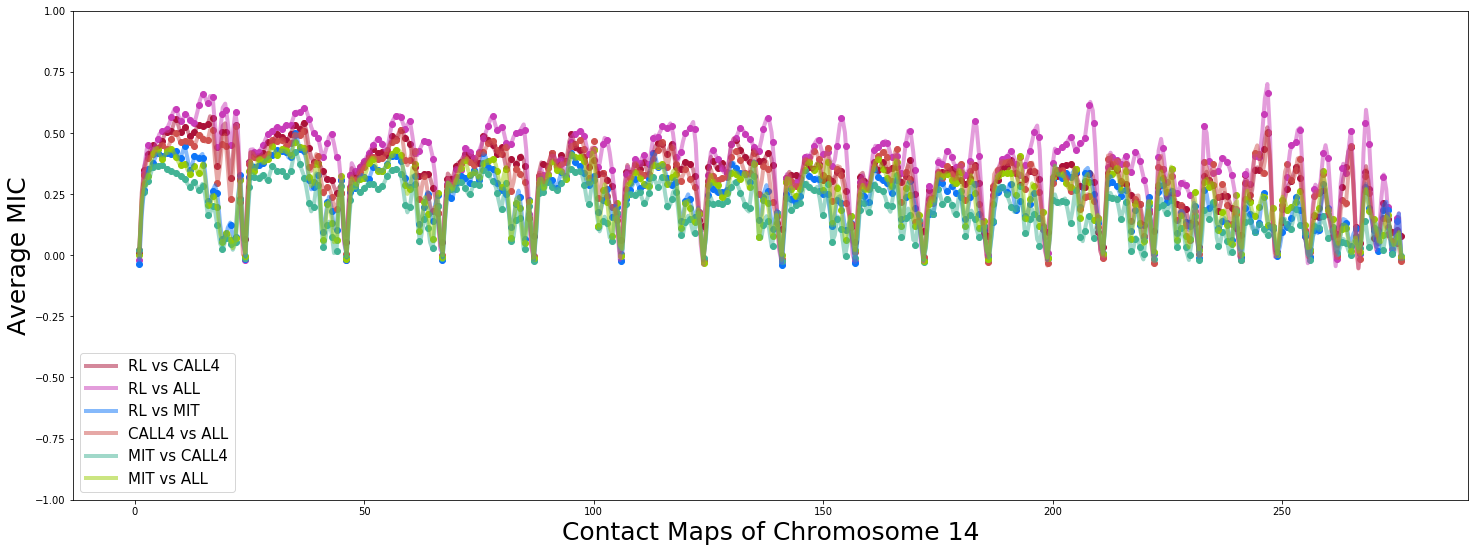

In [13]:
pylab.rcParams['figure.figsize'] = (200, 90)
custIndices = []
chr1 = 14
for chr2 in range(1, 24):
    if chr1 < chr2:
        custIndices.append(chr2count[(chr1, chr2)])
    else:
        custIndices.append(chr2count[(chr2, chr1)])
print(mics['mit']['rl'].shape)
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(mics['mit']['rl']))
ax = plt.subplot(1, 1, 1)
cancer_count = mit_count = 0
for cell1 in cellPair2num:
    for cell in cellPair2num[cell1]:
        tmp = vectorMic - np.mean(vectorMic, axis=(0, 2), keepdims=True)
        y = np.nanmean(tmp[cellPair2num[cell1][cell]][:, :][:, indices], axis=1) 
        
        x = np.array(range(len(y))) + 1
        xnew = np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
        y_smooth = spline(x, y,xnew)
        if cell1 == 'mit' or cell == 'mit':
            color = mit_colors[mit_count]
            mit_count += 1
        else:
            color = cancer_colors[cancer_count]
            cancer_count += 1
        ax.scatter(x, y, color=color)
        ax.plot(xnew, y_smooth, marker=" ", label="%s vs %s"%(cell1.upper(), cell.upper())\
                , linewidth=4, alpha=.5, color=color)
        ax.set_ylim([-1, 1])
        ax.set_xlabel("Contact Maps of Chromosome %d"%(chr1), fontsize=25)
        ax.set_ylabel("Average MIC", fontsize=25)
        #ax.set_xticks(x)
plt.legend(prop={'size':15})
plt.show()

(276, 73)


/home/bzr0014/git/watson/virt/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


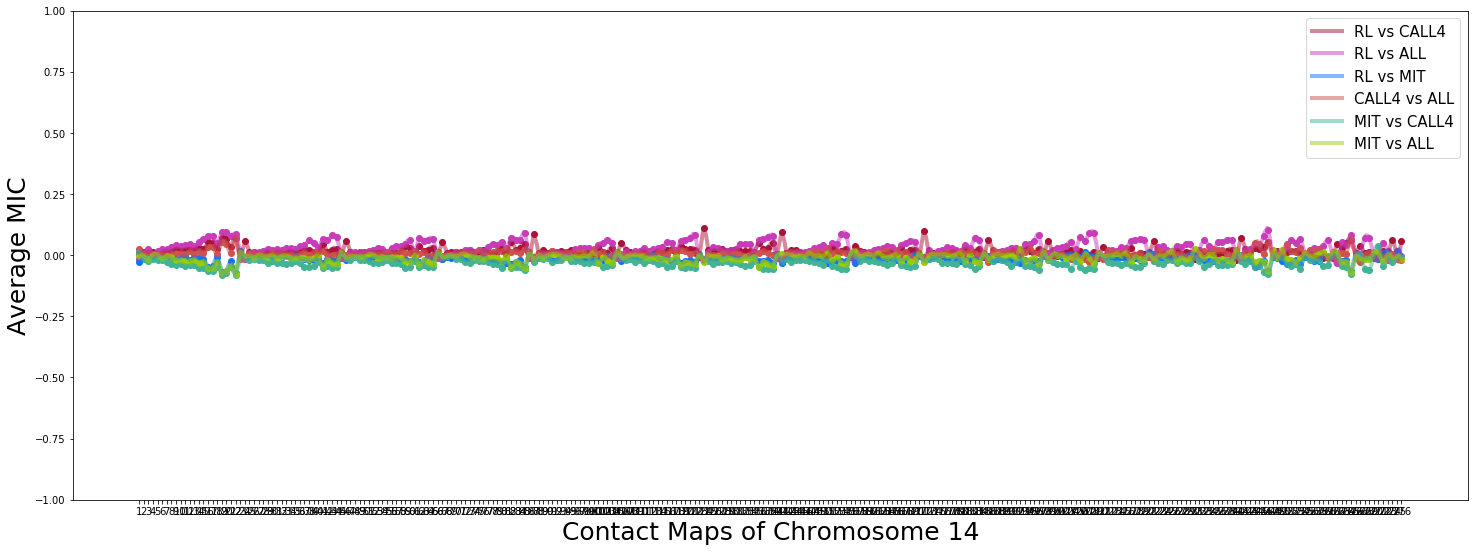

In [299]:
pylab.rcParams['figure.figsize'] = (200, 90)
custIndices = []
chr1 = 14
for chr2 in range(1, 24):
    if chr1 < chr2:
        custIndices.append(chr2count[(chr1, chr2)])
    else:
        custIndices.append(chr2count[(chr2, chr1)])
print(mics['mit']['rl'].shape)
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(mics['mit']['rl']))
ax = plt.subplot(1, 1, 1)
cancer_count = mit_count = 0
for cell1 in cellPair2num:
    for cell in cellPair2num[cell1]:
        tmp = vectorMic - np.mean(vectorMic, axis=(0, 2), keepdims=True)
        y = np.nanmean(tmp[cellPair2num[cell1][cell]][:, :][:, :], axis=1) 
        
        x = np.array(range(len(y))) + 1
        xnew = np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
        y_smooth = spline(x, y,xnew)
        if cell1 == 'mit' or cell == 'mit':
            color = mit_colors[mit_count]
            mit_count += 1
        else:
            color = cancer_colors[cancer_count]
            cancer_count += 1
        ax.scatter(x, y, color=color)
        ax.plot(xnew, y_smooth, marker=" ", label="%s vs %s"%(cell1.upper(), cell.upper())\
                , linewidth=4, alpha=.5, color=color)
        ax.set_ylim([-1, 1])
        ax.set_xlabel("Contact Maps of Chromosome %d"%(chr1), fontsize=25)
        ax.set_ylabel("Average MIC", fontsize=25)
        ax.set_xticks(x)
plt.legend(prop={'size':15})
plt.show()

(276, 73)


/home/bzr0014/git/watson/virt/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


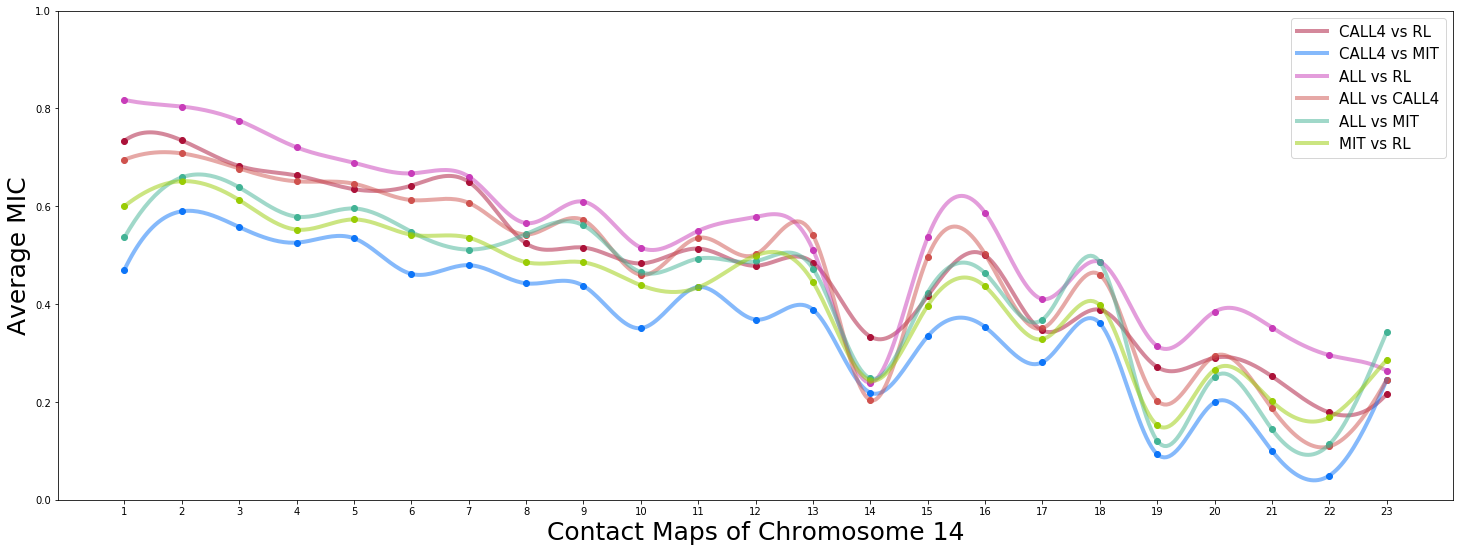

In [288]:
pylab.rcParams['figure.figsize'] = (200, 90)
custIndices = []
chr1 = 14
for chr2 in range(1, 24):
    if chr1 < chr2:
        custIndices.append(chr2count[(chr1, chr2)])
    else:
        custIndices.append(chr2count[(chr2, chr1)])
print(mics['mit']['rl'].shape)
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(mics['mit']['rl']))
ax = plt.subplot(1, 1, 1)
cancer_count = mit_count = 0
for cell1 in mics:
    for cell in mics[cell1]:
        if cell < cell1:
            continue
        y = np.nanmean(mics[cell1][cell][custIndices, :][:, indices], axis=1)
        x = np.array(range(len(y))) + 1
        xnew = np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
        y_smooth = spline(x, y,xnew)
        if cell1 == 'mit' or cell == 'mit':
            color = mit_colors[mit_count]
            mit_count += 1
        else:
            color = cancer_colors[cancer_count]
            cancer_count += 1
        ax.scatter(x, y, color=color)
        ax.plot(xnew, y_smooth, marker=" ", label="%s vs %s"%(cell1.upper(), cell.upper())\
                , linewidth=4, alpha=.5, color=color)
        ax.set_ylim([0, 1])
        ax.set_xlabel("Contact Maps of Chromosome %d"%(chr1), fontsize=25)
        ax.set_ylabel("Average MIC", fontsize=25)
        ax.set_xticks(x)
plt.legend(prop={'size':15})
plt.show()

In [14]:
chr2count[(2, 23)]

44

/home/bzr0014/git/watson/virt/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if sys.path[0] == '':


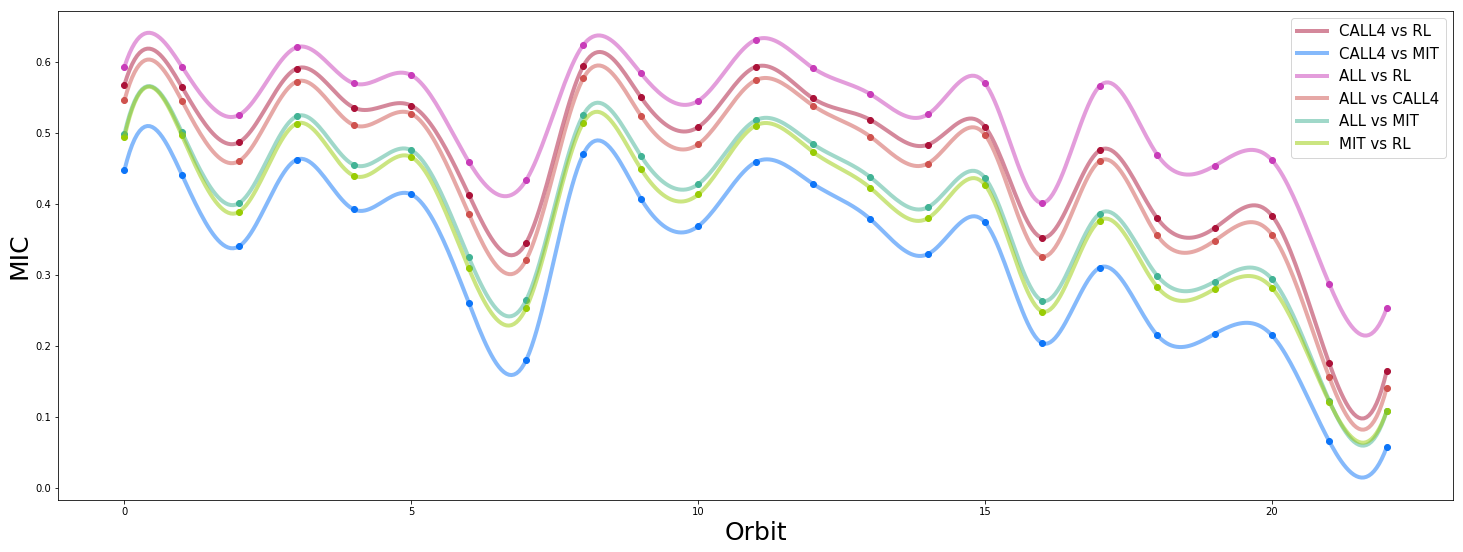

In [47]:
pylab.rcParams['figure.figsize'] = (25, 9)
ax = plt.subplot(1, 1, 1)
legends = []
mit_count = cancer_count = 0
for chosen_cell in mics:
    for cell in mics[chosen_cell]:
        if cell < chosen_cell:
            continue
        y = np.nanmean(mics[chosen_cell][cell][:,indices], axis=0)
        x = np.array(range(len(y)))
        xnew = np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
        y_smooth = spline(x, y,xnew)
        if chosen_cell == 'mit' or cell == 'mit':
            color = mit_colors[mit_count]
            mit_count += 1
        else:
            color = cancer_colors[cancer_count]
            cancer_count += 1 
        ax.scatter(x, y, color=color)
        tmp, = ax.plot(xnew, y_smooth, marker=" ", label="%s vs %s"%(chosen_cell.upper(), cell.upper())\
                       , linewidth=4, alpha=.5, color=color)
        #tmp, = ax.plot(x, y, marker=".", label="%s vs %s"%(chosen_cell, cell))
        legends.append(tmp)
        ax.set_xlabel('Orbit', fontsize=25)
        ax.set_ylabel('MIC', fontsize=25)
plt.legend(handles=legends, loc=1, prop={'size':15})
plt.show()

## MIC statsitical analysis

### Comparison between contact maps

### Comparison between contact maps only considering non-zero orbits

### Comparison between orbits

### Comparison between orbits only for intra-chromosomal contact maps

In [312]:
numData = 0
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        datashape = mics[cell1][cell2].shape
        numData += 1
axis = 1
xIndices = range(276)
yIndices = range(73)
yIndices = indices
averages = []
counts = []
data = {}
count = 0
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue        
        tag = "%s vs %s"%(cell1, cell2)
        tmp = mics[cell1][cell2][xIndices, :][:, yIndices]
        averages.append(np.mean(tmp, axis=1-axis))
        counts.append(tmp.shape[1-axis])           
        if axis == 1:
            data[tag] = tmp
        else:
            data[tag] = tmp.T
        count += 1
averages = np.array(averages)
counts = np.array(counts, dtype='uint32').reshape(-1, 1)
print(averages.shape)

(6, 23)


In [313]:
print(data.keys())
manova(data, method='wilk')

['all vs rl', 'call4 vs mit', 'mit vs rl', 'all vs call4', 'all vs mit', 'call4 vs rl']
Method Used: WILK
('n: ', 1656.0)
('k: ', 23)
('m: ', 6)
('a: ', 1640.5)
('b_num', 13221.0)
('b_denom', 549.0)
('b: ', 4.907338098512752)
('c: ', 56.5)
('gamma: ', 0.5654068065417478)
('s', 5)
('t', 8.5)
('u', 813.0)
('df1', 115)
('df2', 7993.988150610169)
('F', 8.565054626003658)
('alpha:', 0.05)
('F-crit:', 1.2284905642879855)
('p-value:', 1.1711969397971584e-128)


(6, 73)
(6, 73)
(6, 73)
(6, 73)
(6, 73)
(6, 73)


/home/bzr0014/git/watson/virt/lib/python2.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


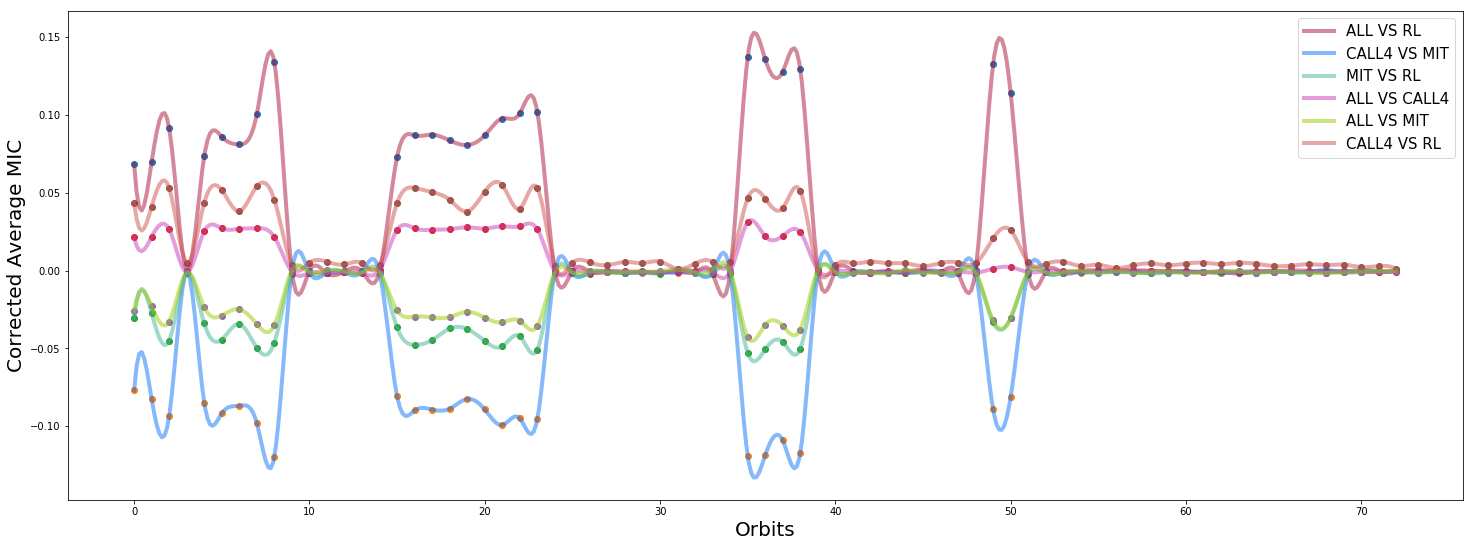

In [296]:
pylab.rcParams['figure.figsize'] = (25, 9)
chr1 = 14
custIndices = []
for chr2 in range(1, 24):
    if chr1 < chr2:
        custIndices.append(chr2count[(chr1, chr2)])
    else:
        custIndices.append(chr2count[(chr2, chr1)])
mit_count = cancer_count = 0
ax = plt.subplot(1, 1, 1)
i = -1
mit_count = cancer_count = 0
for tag in data:
    i += 1
    print(averages.shape)
    means = np.mean(averages, axis=0)
    y = (np.nanmean(data[tag], axis=0) - means)
    x = np.array(range(len(y)))
    xnew = np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
    y_smooth = spline(x, y,xnew)
    ax.scatter(x, y)
    if tag.find('mit') >= 0:
        color = mit_colors[mit_count]
        mit_count += 1
    else:
        color = cancer_colors[cancer_count]        
        cancer_count += 1
    ax.plot(xnew, y_smooth, marker=" ", label="%s"%(tag.upper())\
            , linewidth=4,  alpha=.5, color=color)       
    #ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
    #ax.set_ylim([-1.5, 1.5])
    ax.set_ylabel('Average loci-loci distance', fontsize=12)
    ax.set_xlabel('Contact maps of chromosome %d'%(chr1), fontsize=12)
    ax.set_ylabel('Corrected Average MIC', fontsize=20)
    ax.set_xlabel('Contact maps of chromosome %d'%(chr1), fontsize=20)
    ax.set_xlabel('Orbits', fontsize=20)    
    #ax.set_xticks(x)
    #ax.set_ylim([-.2, .2])

plt.legend(prop={'size':15})
plt.show()

In [297]:
newData = {'normal vs cancer':[], 'cancer vs cancer':[]}
for tag in data:
    if tag.find('mit') >= 0:
        newData['normal vs cancer'].append(data[tag])
    else:
        newData['cancer vs cancer'].append(data[tag])
for tag in newData:
    print(tag)
    newData[tag] = np.array(newData[tag])
    newData[tag] = newData[tag].reshape(-1, newData[tag].shape[2])
    print(newData[tag].shape)

normal vs cancer
(828, 73)
cancer vs cancer
(828, 73)


In [300]:
print(newData.keys())
manova(newData, method='wilk')

['normal vs cancer', 'cancer vs cancer']
Method Used: WILK
('n: ', 1656.0)
('k: ', 73)
('m: ', 2)
('a: ', 1617.5)
('b_num', 5325.0)
('b_denom', 5325.0)
('b: ', 1.0)
('c: ', 35.5)
('gamma: ', 0.774924454269296)
('s', 1)
('t', 35.5)
('u', 790.0)
('df1', 73)
('df2', 1582.0)
('F', 6.294374296114487)
('alpha:', 0.05)
('F-crit:', 1.2962031314614704)
('p-value:', 8.492100057412376e-49)


(6, 73)
(6, 73)


/home/bzr0014/git/watson/virt/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


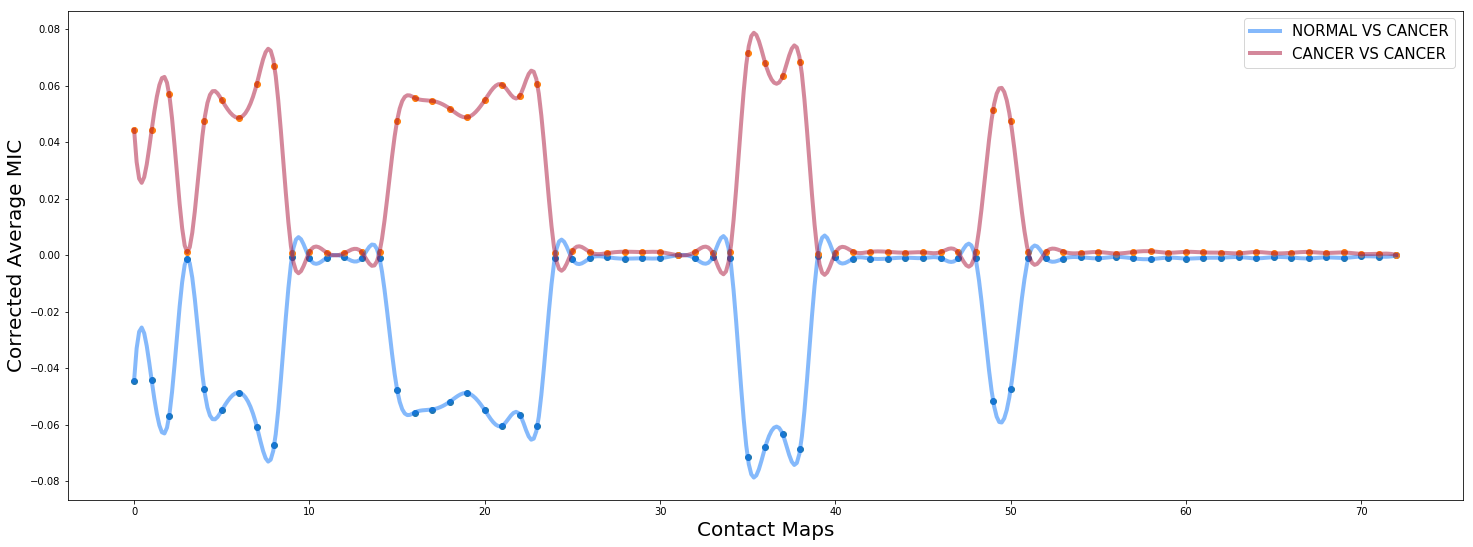

In [299]:
pylab.rcParams['figure.figsize'] = (25, 9)
chr1 = 14
custIndices = []
for chr2 in range(1, 24):
    if chr1 < chr2:
        custIndices.append(chr2count[(chr1, chr2)])
    else:
        custIndices.append(chr2count[(chr2, chr1)])
mit_count = cancer_count = 0
ax = plt.subplot(1, 1, 1)
i = -1
mit_count = cancer_count = 0
for tag in newData:
    i += 1
    print(averages.shape)
    means = np.mean(averages, axis=0)
    y = (np.mean(newData[tag], axis=0) - means)
    y_err = np.std(newData[tag], axis=0) * .1
    x = np.array(range(len(y)))
    xnew = np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
    y_smooth = spline(x, y,xnew)
    if tag == 'normal vs cancer':
        color1 = mit_colors[0]
        color2 = mit_colors[1]
    else:
        color1 = cancer_colors[0]
        color2 = cancer_colors[1]
    ax.scatter(x, y)
    ax.plot(xnew, y_smooth, marker=" ", label="%s"%(tag.upper())\
            , linewidth=4,  alpha=.5, color=color1)
    #ax.errorbar(x, y, yerr=y_err, linestyle="dashed", marker="None", color=color2)
    #ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
    #ax.set_ylim([-1.5, 1.5])
    ax.set_ylabel('Corrected Average MIC', fontsize=20)
    ax.set_xlabel('Contact maps of chromosome %d'%(chr1), fontsize=20)
    ax.set_xlabel('Contact Maps', fontsize=20)
    #ax.set_xticks(x)
    #ax.set_ylim([-.3, .3])

plt.legend(prop={'size':15})
plt.show()

In [150]:
data = {}
data['loam'] = np.array([[76.7, 29.5, 7.5], 
[60.5, 32.1, 6.3], 
[96.1, 40.7, 4.2], 
[88.1, 45.1, 4.9], 
[50.2, 34.1, 11.7], 
[55, 31.1, 6.9], 
[65.4, 21.6, 4.3], 
[65.7, 27.7, 5.3]])
data['sandy'] = np.array([[67.3, 48.3, 5.5], 
[61.3, 28.9, 6.9         ], 
[58.2, 42.5, 4.8         ], 
[76.9, 20.4, 3           ], 
[66.9, 23.9, 1.1         ], 
[55.4, 29.1, 5           ], 
[50.5, 18, 4.8           ], 
[64.1, 14.5, 3.7         ]])
data['salty'] = np.array([[62.8, 25.9, 2.9],
[45, 15.9, 1.2, ],
[47.8, 36.1, 4.1, ],
[75.6, 27.7, 6.3, ],
[46.6, 46.9, 3.6, ],
[50.6, 29.7, 4.7, ],
[45.7, 27.6, 6.2, ],
[68.4, 35.3, 1.9, ]])

data['clay'] = np.array([[52.5, 39, 3.1],
[80, 54.2, 4, ],
[54.7, 32.1, 5.7, ],
[63.5, 25.6, 3, ],
[46.3, 31.8, 7.4, ],
[61.5, 16.8, 1.9, ],
[62.9, 25.8, 2.4, ],
[49.3, 39.4, 5.2, ]])

In [151]:
manova(data, method='wilk')

Method Used: WILK
('n: ', 32.0)
('k: ', 3)
('m: ', 4)
('a: ', 27.5)
('b_num', 77.0)
('b_denom', 13.0)
('b: ', 2.433737233777904)
('c: ', 3.5)
('gamma: ', 0.4894137829018365)
('s', 3)
('t', -0.5)
('u', 12.0)
('df1', 9)
('df2', 63.427773928892364)
('F', 2.404957370867775)
('alpha:', 0.05)
('F-crit:', 2.0311843684584736)
('p-value:', 0.020471936357815974)


In [172]:
numData = 0
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        datashape = distances[cell1][cell2].shape
        print(datashape)
        numData += 1
axis = 1
xIndices = range(276)
yIndices = range(1)
yIndices = indices
averages = []
counts = []
data = {}
count = 0
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue        
        tag = "%s vs %s"%(cell1, cell2)
        tmp = distances[cell1][cell2][:, 0].reshape(-1, 1)
        averages.append(np.mean(tmp, axis=1-axis))
        counts.append(tmp.shape[1-axis])           
        if axis == 1:
            data[tag] = tmp
        else:
            data[tag] = tmp.T
        count += 1
averages = np.array(averages)
counts = np.array(counts, dtype='uint32').reshape(-1, 1)
print(averages.shape)

(276, 4)
(276, 4)
(276, 4)
(276, 4)
(276, 4)
(276, 4)
(6, 1)


In [173]:
manova(data, method='wilk')

Method Used: WILK
('n: ', 1656.0)
('k: ', 1)
('m: ', 6)
('a: ', 1651.5)
('b_num', 21.0)
('b_denom', 21.0)
('b: ', 1.0)
('c: ', 1.5)
('gamma: ', 0.9111131405886976)
('s', 1)
('t', 1.5)
('u', 824.0)
('df1', 5)
('df2', 1650.0)
('F', 32.19431517229249)
('alpha:', 0.05)
('F-crit:', 2.219521132720305)
('p-value:', 2.1404345664824635e-31)


(6, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)
(6, 1)


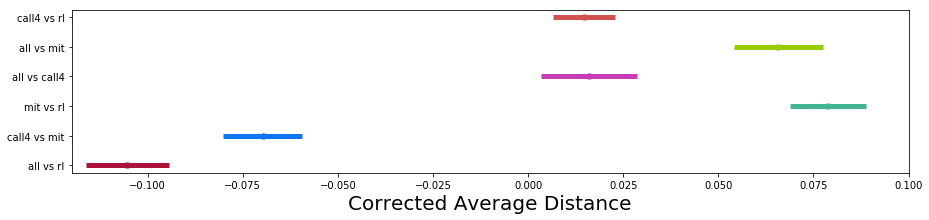

In [292]:
pylab.rcParams['figure.figsize'] = (15, 3)
chr1 = 14
custIndices = []
for chr2 in range(1, 24):
    if chr1 < chr2:
        custIndices.append(chr2count[(chr1, chr2)])
    else:
        custIndices.append(chr2count[(chr2, chr1)])
mit_count = cancer_count = 0
ax = plt.subplot(1, 1, 1)
i = -1
mit_count = cancer_count = 0
for tag in data:
    i += 1
    print(averages.shape)
    means = np.mean(averages, axis=0)
    x = (np.mean(data[tag], axis=0) - means)
    x_err = np.std(data[tag], axis=0) * .05
    y = np.ones_like(x) * i*.1
    xnew = x#np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
    y_smooth = y#spline(x, y,xnew)
    if tag.find('mit') >= 0:
        color1 = mit_colors[mit_count]
        color2 = mit_colors[mit_count]
        mit_count+=1
    else:
        color1 = cancer_colors[cancer_count]
        color2 = cancer_colors[cancer_count]
        cancer_count += 1
    ax.plot(xnew, y_smooth, marker="o", label="%s"%(tag.upper())\
            , linewidth=5,  alpha=.5, color=color1)
    ax.errorbar(x, y, xerr=x_err, linestyle="dashed", marker="None", color=color1, linewidth=5)
    #ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
    #ax.set_ylim([-1.5, 1.5])
    #ax.set_ylabel('Corrected Average MIC', fontsize=20)
ax.set_xlabel('Corrected Average Distance', fontsize=20)
ax.set_yticks(np.arange(len(data))*.1)
ax.set_yticklabels(data.keys())
ax.set_xlim([-.12, .1])

#plt.legend(prop={'size':15})
plt.show()

In [262]:
newData = {'normal vs cancer':[], 'cancer vs cancer':[]}
for tag in data:
    if tag.find('mit') >= 0:
        newData['normal vs cancer'].append(data[tag])
    else:
        newData['cancer vs cancer'].append(data[tag])
for tag in newData:
    print(tag)
    newData[tag] = np.array(newData[tag])
    newData[tag] = newData[tag].reshape(-1, newData[tag].shape[2])
    print(newData[tag].shape)

normal vs cancer
(828, 1)
cancer vs cancer
(828, 1)


In [263]:
print(newData.keys())
manova(newData, method='hotelling')

['normal vs cancer', 'cancer vs cancer']
Method Used: HOTELLING
('n: ', 1656.0)
('k: ', 1)
('m: ', 2)
('s', 1)
('t', -0.5)
('u', 826.0)
('T20: ', 0.012390436681119634)
('df1', 1.0)
('df2', 1654.0)
('F', 20.493782270571874)
('alpha:', 0.05)
('F-crit:', 3.8470871354481613)
('p-value:', 6.409969039925188e-06)


(6, 1)
(6, 1)


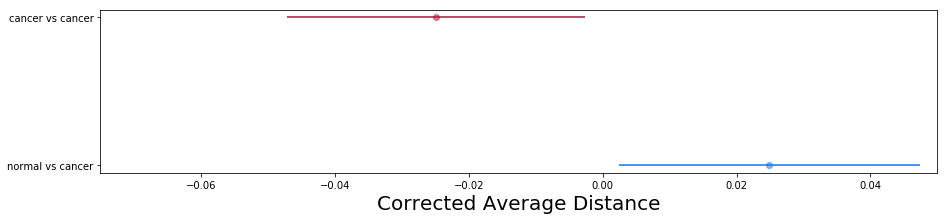

In [291]:
pylab.rcParams['figure.figsize'] = (15, 3)
chr1 = 14
custIndices = []
for chr2 in range(1, 24):
    if chr1 < chr2:
        custIndices.append(chr2count[(chr1, chr2)])
    else:
        custIndices.append(chr2count[(chr2, chr1)])
mit_count = cancer_count = 0
ax = plt.subplot(1, 1, 1)
i = -1
mit_count = cancer_count = 0
for tag in newData:
    i += 1
    print(averages.shape)
    means = np.mean(averages, axis=0)
    x = (np.mean(newData[tag], axis=0) - means)
    x_err = np.std(newData[tag], axis=0) * .1
    y = np.ones_like(x) * i*.1
    xnew = x#np.linspace(x.min(),x.max(),500) #300 represents number of points to make between T.min and T.max
    y_smooth = y#spline(x, y,xnew)
    if tag == 'normal vs cancer':
        color1 = mit_colors[0]
        color2 = mit_colors[1]
    else:
        color1 = cancer_colors[0]
        color2 = cancer_colors[1]    
    #ax.scatter(x, y)
    ax.plot(xnew, y_smooth, marker="o", label="%s"%(tag.upper())\
            , linewidth=3,  alpha=.5, color=color1)
    ax.errorbar(x, y, xerr=x_err, linestyle="dashed", marker="None", color=color1)
    #ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
    #ax.set_ylim([-1.5, 1.5])
    #ax.set_ylabel('Corrected Average MIC', fontsize=20)
    ax.set_xlabel('Corrected Average Distance', fontsize=20)
    ax.set_yticks(np.arange(len(newData))*.1)
    ax.set_yticklabels(newData.keys())
    ax.set_xlim([-.075, .050])

#plt.legend(prop={'size':15})
plt.show()